<a href="https://colab.research.google.com/github/myrronaguila/analyze_sqc/blob/main/Plots/Single_Qubit_Coherence_Time_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probability Density Estimation of Statistical and Time Series Data for Qubit Lifetime Characterization
by Myrron Albert Callera Aguila, PhD (First Updated 2023-09-06)

This notebook introduces people to probability density distribution using python, and how time series or data with multiple samples can have its probability density function reconstructed with (1) histograms (2) Integrated Histograms (or Empirical Cumulative Distribution functions and (3) Probability Density Distributions.

###Disclaimer:

For users of this notebook who find the contents here useful for their ongoing work, please cite or acknowledge my contribution to your work, no matter how small it is. This means a lot. Ideas put in this package took months or even years of expertise to implement.

In [ ]:
!pip install lmfit==1.2.2

In [ ]:
# Imported libraries
import numpy as np #numpy 1.25
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import inspect #useful for printing python modules uploaded
import sys #for printing imported python modules and versions

#for KDE
from scipy import stats
from sklearn.neighbors import KernelDensity
from lmfit.models import GaussianModel
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm

# Example of $T_{1}$ spectroscopy / time domain binning

We first initialize qubit $T_{1}$ with a dummy gaussian noise fluctuation. We set the $T_{1}$ of this qubit to be 50 $\mu$s, and scan relevant parameters such qubit idle time in terms of hours. The rough layout of the plots are inspired from "Lisenfeld, J., Bilmes, A., & Ustinov, A. V. (2023). Enhancing the coherence of superconducting quantum bits with electric fields. npj Quantum Information, 9(1). doi:10.1038/s41534-023-00678-9".

## Gaussian Distribution



In [ ]:
# set dummy variables
counts = 181 #10 minutes, 60 pts => 10 seconds per point
t_arr = np.linspace(0, 30, counts) #in minutes
mu, sigma = 100, 20 #mean, standard deviation and Amplitude of Gaussian distrubution

T1_arr = np.random.normal(loc=mu, scale=sigma, size=counts) # spread of T1 in us.
#error of fit must be uniform if given the same parameters to resolve T1 from time domain

T1_err_arr = np.random.uniform(low=0, high=1, size=counts) # spread of error of fit model in us.
#this error is essentially controlled by the averaging and sampling of the measurement

Alternatively, one can upload listed measured values and their standard deviations and fit them according to their fit error. This can be done by saving analyzed data in repository softwares, and plotting them in .mat files.

Check for initial distribution of the $T_{1}$ depending on width of the bin


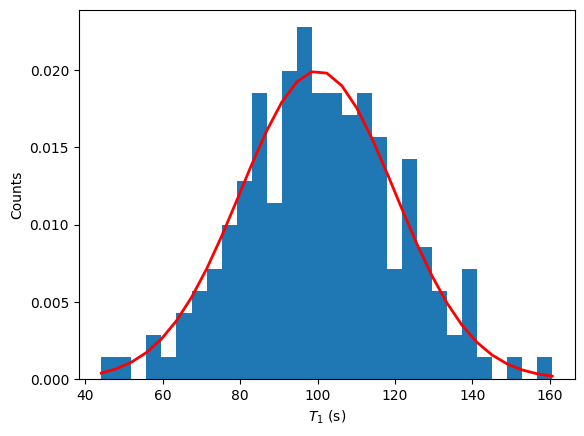

In [ ]:
# check for gaussian distribution of T1 distribution
# references: https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
n_bins = 30
count, bins, ignored = plt.hist(T1_arr, n_bins, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.xlabel(r'$T_{1}$ (s)')
plt.ylabel(r'Counts')
plt.show()

Make Gaussian Distribution Functions and Empirical Distribution Functions to assess data integrity without discounting histogram performance.

In [ ]:
#plot gaussian pdf and cdf functions, as suggested by prof. Martinis

def ecdf(a):
  #ecdf depending on array of data
  #https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python
    # a represents set of data obtained from the distribution over long time spans
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def plot_ecdf(a):
  #convert ecdf to x,y cdf for step-post
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    #plt.plot(x, y, drawstyle='steps-post')
    return x,y

def plot_epdf(a):
  #extract epdf from step-post, query from chatgpt-misses the mark
    x, y = ecdf(a)
    y_pdf = np.diff(y)
    #x = np.insert(x, 0, x[0]) #initiate line
    y_pdf = np.insert(y_pdf, 0, 0.) #probability distribution starts from 0.
    return x, y_pdf

def gaussian_pdf_cdf(x, mu, sigma):
  #plot pdf and cdf of an ideal gaussian function
  y_pdf= (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * (1 / sigma * (x - mu))**2)
  #CDF
  #https://matplotlib.org/stable/gallery/statistics/histogram_cumulative.html - histogram
  y_cdf = y_pdf.cumsum()
  y_cdf /= y_cdf[-1]
  return y_pdf, y_cdf

#ax1t.hist(T1_arr, n_bins, color='tab:orange', density=True, histtype='step',
#          cumulative=True, label='CDF_data') #it has bin-width
#ax1t.hist shows fall off data, when approaching end. Better use axes line plots


Testing EDF and Plots

In [ ]:
# make good differential diagram for the measurement. Probability distribution and CDF for T1

#representative Gaussian pdf and cdf
gauss_pdf, gauss_cdf = gaussian_pdf_cdf(x=bins, mu=mu, sigma=sigma)

#empirical cdf and pdfs
bin_ecdf, count_ecdf = plot_ecdf(T1_arr) #empirical cumulative distributions make sense
#bin_epdf, count_epdf = plot_epdf(T1_arr)
#sampling pdf does not make sense because of the measurements

Plot graphs.

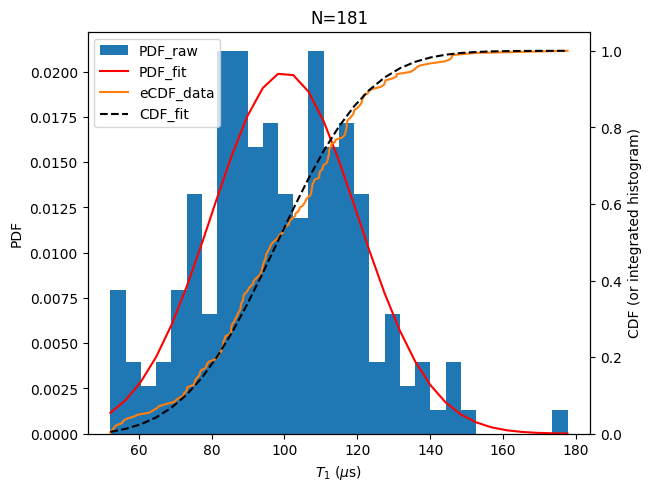

In [ ]:
#Plot data
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)
ax1 = fig.add_subplot(spec[0, 0]) #scatter plot
ax1t = ax1.twinx()

#probability distribution histogram
count, bins, ignored = ax1.hist(T1_arr, n_bins, density=True, histtype='bar',
                                label='PDF_raw')

# model function
ax1.set_title('N={:1d}'.format(len(T1_arr)))
ax1.plot(bins, gauss_pdf, color='r', label='PDF_fit')
ax1.set_xlabel(r'$T_{1}$ ($\mu$s)')
ax1.set_ylabel(r'PDF')
#ax1.set_xlim(bins[0], bins[-1])

#show integrated histogram / cdf in rectangular
#line plots - empirical cumulative distribution function

#ax1t.plot(bin_ecdf, count_ecdf, color='tab:orange', drawstyle='steps-post', label='eCDF_data')
ax1t.plot(bin_ecdf, count_ecdf, color='tab:orange', label='eCDF_data')
#line showing the expected cumulative distribution; Add a line showing the expected distribution.
ax1t.plot(bins, gauss_cdf, 'k--', linewidth=1.5, label='CDF_fit')

#ax1t.set_xlabel(r'$T_{1}$ ($\mu$s)')
ax1t.set_ylabel(r'CDF (or integrated histogram)')

#ax1t.set_xlim(bins[0], bins[-1])
ax1t.set_ylim(0,1.05)

#Combine legends in one diagram
#https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1t.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

#for other references, refer to this. #https://www.geeksforgeeks.org/how-to-calculate-and-plot-a-cumulative-distribution-function-with-matplotlib-in-python/


##Uniform distribution function

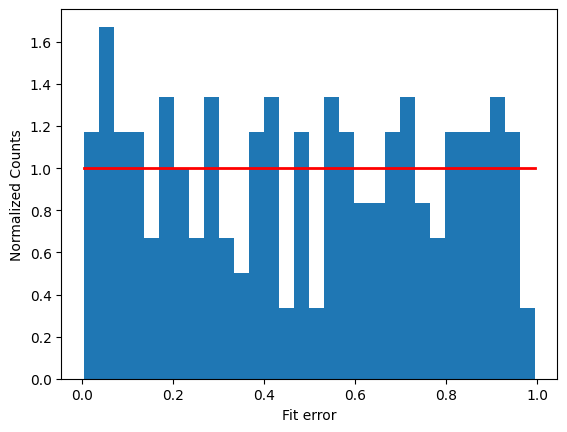

In [ ]:
# check for fit error with a probability distribution
# https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
n_bins = 30
count_err, bins_err, ignored = plt.hist(T1_err_arr, n_bins, density=True)
plt.plot(bins_err, np.ones_like(bins_err), linewidth=2, color='r')
plt.xlabel(r'Fit error')
plt.ylabel(r'Normalized Counts')
plt.show()

Create PDF and eCDF for the Uniform Distribution

In [ ]:
def uniform_pdf_cdf(x,a,b):
  #plot pdf and cdf in a uniform distribution
  y_pdf = np.asarray([1/(b-a) for i in range(len(x))])
  y_cdf = y_pdf.cumsum()
  y_cdf /= y_cdf[-1]
  return y_pdf, y_cdf

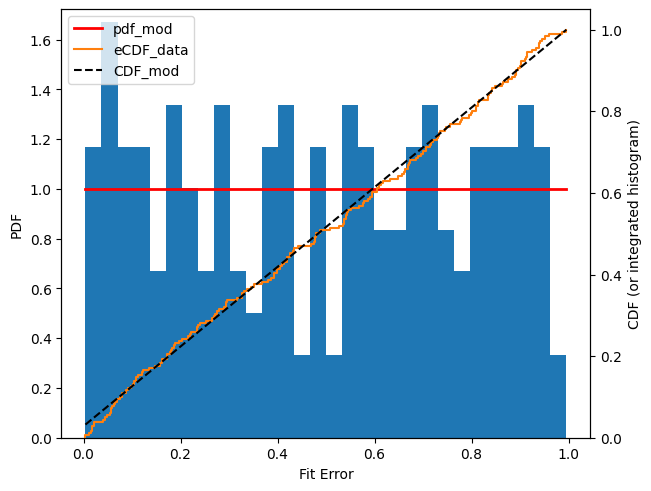

In [ ]:
# make probability distribution and CDF for T1_error of fit

fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05,
                                 wspace=0.05)
ax1 = fig.add_subplot(spec[0, 0]) #scatter plot
ax1t = ax1.twinx()

#theoretical uniform cdf and pdf

y_pdf_err, y_cdf_err = uniform_pdf_cdf(x=np.linspace(0,1,n_bins+1),a=-0.05,b=1)

#probability distribution histogram
count_err, bins_err, ignored = ax1.hist(T1_err_arr, n_bins, density=True)
#representative Gaussian
#get PDF = # finding the PDF of the histogram using count values
ax1.plot(bins_err, np.ones_like(bins_err), linewidth=2, color='r', label='pdf_mod')
ax1.set_xlabel(r'Fit Error')
ax1.set_ylabel(r'PDF')
ax1.set_ylim(0,np.amax(count_err)+0.05)

#CDF
#https://matplotlib.org/stable/gallery/statistics/histogram_cumulative.html
#cdf_err = np.cumsum(pdf_err)
#get CDF
#show integrated histogram / cdf in rectangular
#line plots - empirical cumulative distribution function
bin_er_ecdf, count_er_ecdf = plot_ecdf(T1_err_arr)
ax1t.plot(bin_er_ecdf, count_er_ecdf, color='tab:orange', drawstyle='steps-post',
          label='eCDF_data')
ax1t.plot(bins_err, y_cdf_err, 'k--', label='CDF_mod')
ax1t.set_ylabel(r'CDF (or integrated histogram)')
ax1t.set_ylim(0,1.05)

#Combine legends in one diagram
#https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1t.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

## Short test for Kernel Density Estimation for Determining Integrated Histogram and Probability Distribution

Extracting the Probability Distribution Function (PDF) from the Empirical Cumulative Distribution Function (ECDF) or Integrated Histograms requires non-parametric distribution tools. Kernel Density Estimation (KDE) helps extract the probability distribution function of numerous data plots without any assumption or priori while avoiding issues of bin width. This process addresses key concerns on representing data using continuous distribution, rather than using histograms. This process adapts to the plotting standards set by Rigetti and IBM regarding qubit relaxation, dephasing and spin echo times, and resistance distributions.

For starters, we use the scipy gaussian.kde for this task.
1. https://machinelearningmastery.com/empirical-distribution-function-in-python/
2. https://ekamperi.github.io/math/2020/12/08/kernel-density-estimation.html
3. https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html
4. https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py
5. https://www.geeksforgeeks.org/simple-1d-kernel-density-estimation-in-scikit-learn/
6. https://stackoverflow.com/questions/70613625/how-can-i-generate-a-cdf-using-kernel-density-estimation-in-python
7. https://stackoverflow.com/questions/68396403/kernel-density-estimation-using-scipys-gaussian-kde-and-sklearns-kerneldensity
8. https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html
9. Optimizing KDE bandwidth: https://stackabuse.com/kernel-density-estimation-in-python-using-scikit-learn/
10. KDE in python. https://stackoverflow.com/questions/70613625/how-can-i-generate-a-cdf-using-kernel-density-estimation-in-python

Using scikit.learn (Stavenga) https://www.geeksforgeeks.org/simple-1d-kernel-density-estimation-in-scikit-learn/

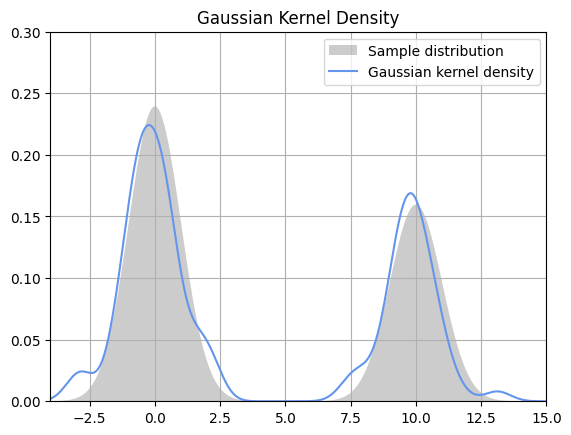

In [ ]:
# https://www.geeksforgeeks.org/simple-1d-kernel-density-estimation-in-scikit-learn/
# Plot the 1D density curve for the gaussian kernel

# Create a sample distribution
N = 100
X = np.concatenate((np.random.normal(0, 1, int(0.6 * N)),
                    np.random.normal(10, 1, int(0.4 * N)))
                )[:, np.newaxis]
X_plot = np.linspace(-5, 15, 1000)[:, np.newaxis]

# Calculate the true density
true_density = 0.6 * stats.norm(0, 1).pdf(X_plot[:, 0]) + 0.4 * stats.norm(10, 1).pdf(X_plot[:, 0])

# Creating a figure
fig, ax = plt.subplots()

# Plotting the true density
ax.fill(
    X_plot[:, 0], true_density,
    fc='black', alpha=0.2,
    label='Sample distribution'
)

# Calculating the density using the gaussian kernel with bandwidth 0.5 - balance between features and size
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)

# Calculating the log of the probability density function
log_dens = kde.score_samples(X_plot)

# Plotting the density curve
ax.plot(
    X_plot[:, 0],
    np.exp(log_dens),
    color="cornflowerblue",
    linestyle="-",
    label="Gaussian kernel density"
)

# Set the title, x and y labels of the plot
ax.set_title("Gaussian Kernel Density")
ax.set_xlim(-4, 15)
ax.set_ylim(0, 0.3)
ax.grid(True)
ax.legend(loc='upper right')

# Display the plot
plt.show()

https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html

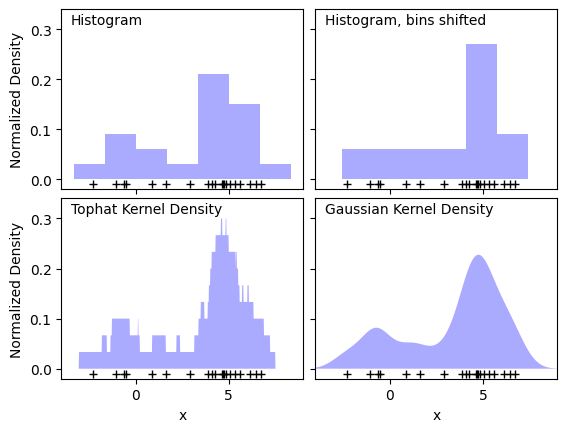

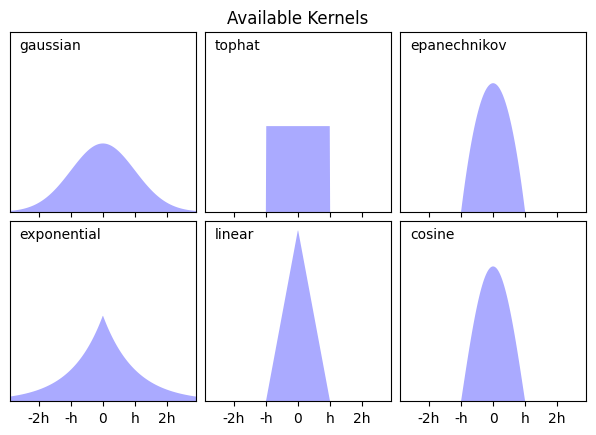

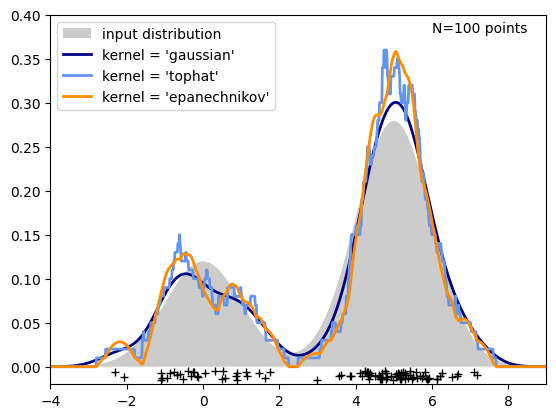

In [ ]:
# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc="#AAAAFF", density=True)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc="#AAAAFF", density=True)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel="tophat", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), "+k")
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel("Normalized Density")

for axi in ax[1, :]:
    axi.set_xlabel("x")

# ----------------------------------------------------------------------
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x


for i, kernel in enumerate(
    ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), "-k", fc="#AAAAFF")
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title("Available Kernels")

# ----------------------------------------------------------------------
# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()

## Code for Optimizing Kernel Density Estimation using Scikit Learn

Create optimizer for Empirical Probability Density Distribution Function introduced by  https://stackabuse.com/kernel-density-estimation-in-python-using-scikit-learn/

In [ ]:
#Create optimizer for empirical probability density distribution
def optimize_kde_pdf(xdata, ydata, bwid_lst, show='Y'):
  """
  Optimize Kernel Density Distribution of Stochastic Data
  Input:
    xdata : 1D numpy array
      interpolating data
    ydata: 1D numpy array
      y-data values to be trained
    kde_bwidth_lst : list of values
      kde_bwid_lst[0] : starting bandwidth based on sample data
      kde_bwid_lst[1] : ending bandwidth based on sample data
      kde_bwid_lst[2] : step bwidth based on sample data
  return:
    y_pdf_opt: 1D numpy array
      Optimized Probability Density Function
    y_cdf_opt: 1D numpy array
      Corresponding Data Functional Distribution
  """
  # prepare necessary arrays for kde analysis
  xdata_interp = xdata[:, np.newaxis]
  ydata_train = ydata[:, np.newaxis]
  h_vals = np.arange(bwid_lst[0], bwid_lst[1], bwid_lst[2])
  kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian',
             'linear', 'tophat']

  #prepare scoring for kernels (data filters at certain bandwidths)
  def my_scores(estimator, X):
    """
    Giving scores to a filter function
    Input :
      estimator : string
        Kernels
      X : 1d numpy array
        float
    """
    scores = estimator.score_samples(X)
    # Remove -inf
    scores = scores[scores != float('-inf')]
    # Return the mean values
    return np.mean(scores)

  #Perform Gridsearch for KDE
  grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': h_vals, 'kernel': kernels},
                    scoring=my_scores)
  grid.fit(ydata_train)
  best_kde = grid.best_estimator_
  log_dens = best_kde.score_samples(xdata_interp) #log max likelihood ratio

  #show report for fit
  if show == 'Y':
    print("Best Kernel: " + best_kde.kernel+" h="+"{:.2f}".format(best_kde.bandwidth))

  #Calculate for Probability Density estimation
  y_pdf_opt = np.exp(log_dens)  #maximum likelihood expressed in PDF

  #obtain numerical cumulative distribution function from KDE
  y_cdf_opt = np.cumsum(y_pdf_opt)
  y_cdf_opt = y_cdf_opt / np.max(y_cdf_opt)
  return y_pdf_opt

def npdf_to_cdf(y_pdf):
  """Convert numerical pdf to cdf"""
  #obtain numerical cumulative distribution function from KDE
  y_cdf_opt = np.cumsum(y_pdf)
  y_cdf_opt = y_cdf_opt / np.max(y_cdf_opt)
  return y_cdf_opt

def Gaussian(x, mu, sigma, Amp):
  # Set an adjustable gaussian distribution
  # for a normalized Gaussian Distribution, Amp=1
  A = 1/(sigma*np.sqrt(2*np.pi))
  B = np.exp(-(x-mu)**2/(2*(sigma**2)))
  return Amp*A*B

def lm_gauss_fit(xdata, ydata, show=['N','N']):
  """
  Gaussian fit from PDF to obtain a statistic using LMFIT library
  Input :
    xdata : 1D numpy array
      x-data fit
    ydata : 1D numpy array
      y-data fit
    show : list of strings
      show[0] = 'Y' - show fit report
      show[1] = 'Y' - show fitting
  """
  mod = GaussianModel()
  pars = mod.guess(ydata, x=xdata)
  init = mod.eval(pars, x=xdata)
  out = mod.fit(ydata, pars, x=xdata)
  if show[0] == 'Y':
    print(out.fit_report(min_correl=0.25))
  if show[1] == 'Y':
    #show amplitude fit
    wfig = 8.6
    fig = plt.figure(constrained_layout=True, figsize=(cm_to_inch(wfig),
                                                       cm_to_inch(wfig)))
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
    ax1 = fig.add_subplot(spec[0, 0])
    ax1.plot(xdata, ydata)
    ax1.plot(xdata, init, '--', label='initial fit')
    ax1.plot(xdata, out.best_fit, '-', label='best fit')
    ax1.set_xlabel('Parameters')
    ax1.set_ylabel('PDF')
    ax1.legend()

  """--Retrieve extracted data from fitting function-------"""
  name = ['amplitude', 'center', 'sigma','fwhm', 'height']
  # strange dictionary
  out_dict_val_stderr = {name[i]: [out.params[name[i]].value,
                                  out.params[name[i]].stderr] for i in range(len(name))}
  return out.best_fit, out_dict_val_stderr

def ecdf(a):
  #ecdf depending on array of data
  #https://stackoverflow.com/questions/24788200/calculate-the-cumulative-distribution-function-cdf-in-python
    # a represents set of data obtained from the distribution over long time spans
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / np.amax(cusum)

def plot_ecdf(a):
  #convert ecdf to x,y cdf for step-post
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    #plt.plot(x, y, drawstyle='steps-post')
    return x,y

#plotting events
def cm_to_inch(x):
  # change font size to 9.0 for publication quality figures
  return x/2.54

## Applications: Time series analysis of Qubit $T_{1}$

We set a scatterplot first using the gridspec command, but then we utilize both histogram bins and KDE for plotting the probability distribution function of T1 from a noisy superconducting quantum processor.

In [ ]:
# set dummy variables
counts = 181 #10 minutes, 60 pts => 10 seconds per point
t_arr = np.linspace(0, 30, counts) #in minutes
mu, sigma = 100, 20 #mean, standard deviation and Amplitude of Gaussian distrubution

T1_arr = np.random.normal(loc=mu, scale=sigma, size=counts) # spread of T1 in us.
#error of fit must be uniform if given the same parameters to resolve T1 from time domain
T1_xval = np.linspace(np.amin(T1_arr), np.amax(T1_arr), counts) #synthetic distribution value x

Best Kernel: tophat h=11.00
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 181
    # variables        = 3
    chi-square         = 9.9782e-05
    reduced chi-square = 5.6057e-07
    Akaike info crit   = -2602.39481
    Bayesian info crit = -2592.79931
    R-squared          = 0.98216107
[[Variables]]
    amplitude:  1.02678783 +/- 0.00661895 (0.64%) (init = 1.354367)
    center:     101.520941 +/- 0.17075056 (0.17%) (init = 100.6928)
    sigma:      23.5035128 +/- 0.18271227 (0.78%) (init = 25.68137)
    fwhm:       55.3465411 +/- 0.43025450 (0.78%) == '2.3548200*sigma'
    height:     0.01742842 +/- 1.0884e-04 (0.62%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = +0.6284


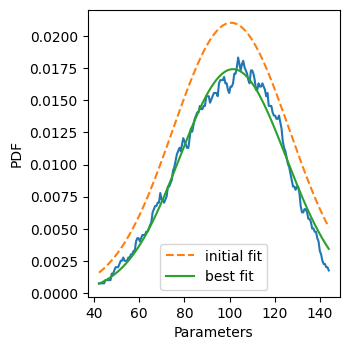

In [ ]:
# Perform fit
# obtain pdf and CDF via kde
T1_pdf_kde = optimize_kde_pdf(xdata=T1_xval, ydata=T1_arr, bwid_lst=[5, 100, 1], show='Y')
T1_cdf_kde = npdf_to_cdf(T1_pdf_kde)

#Gaussian Fit for PDF
T1_pdf_fit, T1_fit_params = lm_gauss_fit(xdata=T1_xval, ydata=T1_pdf_kde, show=['Y','Y'])
T1_cdf_fit = npdf_to_cdf(T1_pdf_fit)

# get experimental CDF
T1_x, T1_ecdf = ecdf(T1_arr) # can be plotted in X-axis

Based on the building of probability distribution function using KDE for a time-series plot

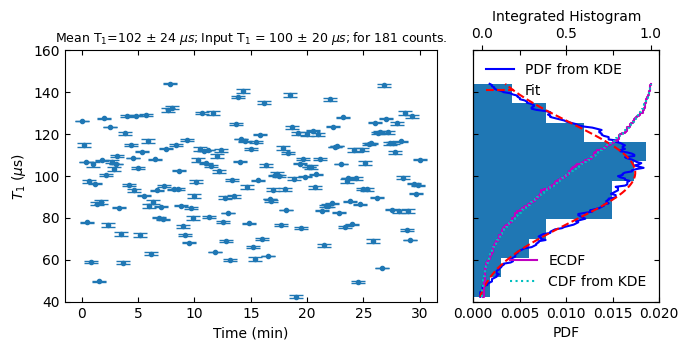

In [ ]:
wfig = 8.6
fig = plt.figure(constrained_layout=True, figsize=(2*cm_to_inch(wfig),
                                                   1*cm_to_inch(wfig)))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05, wspace=0.05,
                         width_ratios=(2, 1))
ax1 = fig.add_subplot(spec[0, 0]) #scatter errorbar plot
ax2 = fig.add_subplot(spec[0, 1], sharey=ax1) #histogram
ax2t = ax2.twiny()

#scatter error bar plot
title = r'Mean T$_{1}$=' +str(round(T1_fit_params['center'][0])) +' $\pm$ ' + str(round(T1_fit_params['sigma'][0])) + ' $\mu s; $'
title1 = r'Input T$_{1}$ = ' + str(round(mu))  + ' $\pm$ ' + str(round(sigma)) + ' $\mu s; $'
title2 = r'for '+str(counts) +' counts.'
ax1.set_title(title + title1 + title2, fontsize=9)
ax1.errorbar(x=t_arr, y=T1_arr, yerr=T1_err_arr, fmt='.', capsize=5)
ax1.set_ylim(40, 160)
ax1.set_xlabel('Time (min)')
ax1.set_ylabel(r'$T_{1}$ ($\mu$s)')
ax1.tick_params(axis='both', which='both', direction='in', top=True, bottom=True)

#draw pdf from kde, y-axis values, x-axis = pdf
#draw bins and fitting
ax2.hist(T1_arr, bins=11, orientation='horizontal', density=True) #experiment with bins
ax2.plot(T1_pdf_kde,T1_xval, 'b-', label='PDF from KDE') #experiment
ax2.plot(T1_pdf_fit,T1_xval, 'r--', label='Fit') #experiment
ax2.tick_params(axis="y", labelleft=False)
ax2.set_xlabel('PDF')
ax2.set_xlim(0, 0.02)
ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax2.legend(loc='upper left', frameon=False)

#draw cdf from kde
ax2t.plot(T1_ecdf, T1_x, 'm-', drawstyle='steps-post', label='ECDF')
ax2t.plot(T1_cdf_kde, T1_xval, 'c:', drawstyle='steps-post', label='CDF from KDE')
ax2t.set_xlabel('Integrated Histogram')
ax2t.legend(loc='lower right', frameon=False)

#plt.savefig('T1_vs_time.png', dpi=300)
plt.show()

## On Histogram vs KDE
Based on simulated T1 vs time data, we see good agreement between the histogram, and the PDF generated by KDE if the bin count approaches the optimized KDE bandwidth. Also, the tophat kernel is best fitted for this distribution, which represents each bins from the histogram. The Integrated histogram between simulated T1 data from random data, and the fitted model has good agreement. This analysis gives good representation of $T_{1}$ distribution, and can be extended to $T_{2}, T_{2,e}$, and qubit fidelities.

## On KDE's limitation in optimization
So far, the tophat filter may give better scores since we initiated a Gaussian distribution but other stochastic distributions may require appropriate or better filters. The goal of the use of the kernels is to smoothen discrete data so that it follows an unknown apriori of a distribution. Also, one must play around the range of values of bandwidth, as not all ranges of bandwidth can give a good descriptor of the PDF. One must be very cautious about the assignment of the bandwidth, especially when there remains non-markovian randomness.  

## Advantage of Empirical Cumulative Distribution Function
The advantage of the empirical cumulative distribution function lies in easily determining the median of the measurement, since these are raw values, as shown in the Google group without need for fancy calculations or prior assumptions of the distribution. Its fit with KDE allows good correspondence with its probability distribution function, which is more informative about the more probable probability density function, and fit the distribution with assumed models.

## Use of ECDF and KDE in reporting statistics

The Quantum Supremacy experiment [1] has demonstrated the use of Empirical Cumulative Distribution Functions for reporting of gate error budgets. Lisenfeld et al [2] and Kosen et al [3] used histogram binning of qubit relaxation and dephasing times in demonstrating superconducting processors based on systematic adjustment of measurement and physical parameters. Notable groups such as Rigetti [4] have utilized KDE for the probability density estimation of fidelities, qubit relaxation times as demonstration of stability of quantum processors.  It is no doubt that advanced machine learning statistical tools would require prudent analysis to get probability distributions right.

In [ ]:
#Lists imported library and versions
#https://stackoverflow.com/questions/66549610/how-to-print-user-imported-module-name-and-version-in-python

module_list=set([x for x in set(sys.modules) & set(globals())] + [value.__name__ for value in globals().values() if inspect.ismodule(value)])

a, na=[], []
print('--module name & versions imported by user--\n')
for name in module_list:
    if name == 'matplotlib.gridspec' or name == 'matplotlib.pyplot':
      name = 'matplotlib'
    try: a.append('{}: {}'.format(name, sys.modules[name].__version__))
    except: na.append('{}: {}'.format(name, 'Not available'))

print(*a,'\n-----\n', *na, sep='\n')

--module name & versions imported by user--

matplotlib: 3.7.1
matplotlib: 3.7.1
numpy: 1.23.5

-----

builtins: Not available
inspect: Not available
sys: Not available


Further References for Time Series Histogram and Kernel Density Estimation of Qubit T1:
1. Arute, F., Arya, K., Babbush, R., Bacon, D., Bardin, J. C., Barends, R., . . . Martinis, J. M. (2019). Quantum supremacy using a programmable superconducting processor. Nature, 574(7779), 505-510. doi:10.1038/s41586-019-1666-5
2. Lisenfeld, J., Bilmes, A., & Ustinov, A. V. (2023). Enhancing the coherence of superconducting quantum bits with electric fields. npj Quantum Information, 9(1). doi:10.1038/s41534-023-00678-9
3. Kosen, S., Li, H.-X., Rommel, M., Shiri, D., Warren, C., Grönberg, L., . . . Bylander, J. (2022). Building blocks of a flip-chip integrated superconducting quantum processor. Quantum Science and Technology, 7(3). doi:10.1088/2058-9565/ac734b
4. Gold, A., Paquette, J. P., Stockklauser, A., Reagor, M. J., Alam, M. S., Bestwick, A., . . . Rigetti, C. (2021). Entanglement across separate silicon dies in a modular superconducting qubit device. npj Quantum Information, 7(1). doi:10.1038/s41534-021-00484-1